<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Predicting Employee Turnover</h1><br>

<img src="images/employee-turnover.png"><br>

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Introduction</h2><br>
**Employee turnover** refers to the percentage of workers who leave an organization and are replaced by new employees. It is very costly for organizations, where costs include but not limited to: separation, vacancy, recruitment, training and replacement. On average, organizations invest between four weeks and three months training new employees. This investment would be a loss for the company if the new employee decided to leave the first year. Furthermore, organizations such as consulting firms would suffer from deterioration in customer satisfaction due to regular changes in Account Reps and/or consultants that would lead to loss of businesses with clients.

In this notebook, we'll work on simulated HR data from [kaggle](https://www.kaggle.com/ludobenistant/hr-analytics) to build a classifier that helps us predict what kind of employees will be more likely to leave given some attributes. Such classifier would help an organization predict employee turnover and be pro-active in helping to solve such costly matter. We'll restrict ourselves to use the most common classifiers: Random Forest, Gradient Boosting Trees, K-Nearest Neighbors, Logistic Regression and Support Vector Machine. 

The data has 14,999 examples (samples). Below are the features and the definitions of each one:
- satisfaction_level: Level of satisfaction {0-1}.
- last_evaluationTime: Time since last performance evaluation (in years).
- number_project: Number of projects completed while at work.
- average_montly_hours: Average monthly hours at workplace.
- time_spend_company: Number of years spent in the company.
- Work_accident: Whether the employee had a workplace accident.
- left: Whether the employee left the workplace or not {0, 1}.
- promotion_last_5years: Whether the employee was promoted in the last five years.
- sales: Department the employee works for.
- salary: Relative level of salary {low, medium, high}.

Let's first load all the packages.

In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             roc_auc_score,
                             roc_curve,
                             confusion_matrix)
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     learning_curve,
                                     validation_curve,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from warnings import filterwarnings

os.chdir("../")
from scripts.plot_roc import plot_conf_matrix_and_roc, plot_roc

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")
filterwarnings("ignore")

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Data Preprocessing</h2><br>
Let's take a look at the data (check if there are missing values and the data type of each features):

In [2]:
# Load the data
df = pd.read_csv("data/HR_comma_sep.csv")

# Check both the datatypes and if there is missing values
print("\033[1m" + "\033[94m" + "Data types:\n" + 11 * "-")
print("\033[30m" + "{}\n".format(df.dtypes))
print("\033[1m" + "\033[94m" + "Sum of null values in each column:\n" + 35 * "-")
print("\033[30m" + "{}".format(df.isnull().sum()))
df.head()

Data types:
-----------
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

Sum of null values in each column:
-----------------------------------
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Since there are no missing values, we do not have to do any imputation. However, there are some data preprocessing needed:
1. Change **sales** feature name to **department**.
2. Convert **salary** into *ordinal categorical* feature since there is intrinsic order between: low, medium and high.
3. Create dummy features from **department** feature and drop the first one to avoid linear dependency where some learning algorithms may struggle with.

In [3]:
# Rename sales feature into department
df = df.rename(columns={"sales": "department"})

# Map salary into integers
salary_map = {"low": 0, "medium": 1, "high": 2}
df["salary"] = df["salary"].map(salary_map)

# Create dummy variables for department feature
df = pd.get_dummies(df, columns=["department"], drop_first=True)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0


In [4]:
df.columns[df.columns != "left"].shape

(17,)

The data is now ready to be used for modeling. The final number of features are now 17.

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Modeling</h2><br>

Let's first take a look at the proportion of each class to see if we're dealing with balanced or imbalanced data since each one has its own set of tools to be used when fitting classifiers.

Positive examples = 3571
Negative examples = 11428
Proportion of positive to negative examples = 31.25%


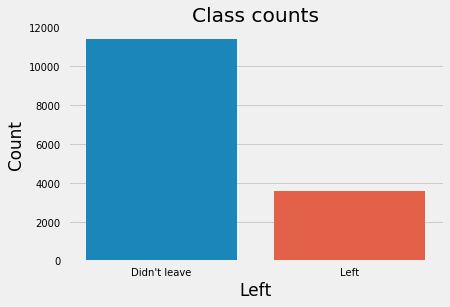

In [5]:
# Get number of positve and negative examples
pos = df[df["left"] == 1].shape[0]
neg = df[df["left"] == 0].shape[0]
print("Positive examples = {}".format(pos))
print("Negative examples = {}".format(neg))
print("Proportion of positive to negative examples = {:.2f}%".format((pos / neg) * 100))
sns.countplot(df["left"])
plt.xticks((0, 1), ["Didn't leave", "Left"])
plt.xlabel("Left")
plt.ylabel("Count")
plt.title("Class counts");

As the graph shows, we have an imbalanced dataset. As a result, when we fit classifiers on such datasets, we should use metrics other than accuracy when comparing models such as *f1-score* or *AUC* (area under ROC curve). Moreover, class imbalance influences a
learning algorithm during training by making the decision rule biased towards the majority class by implicitly learns a model that optimizes the predictions based on the majority class in the dataset. There are three ways to deal with this issue:
1. Assign a larger penalty to wrong predictions from the minority class.
2. Upsampling the minority class or downsampling the majority class.
3. Generate synthetic training examples.

Nonetheless, there is no definitive guide or best practices to deal with such situations. Therefore, we have to try them all and see which one works better on the problem at hand. We'll restrict ourselves to use the first two, i.e assign larger penalty to wrong predictions from the minority class using `class_weight` in classifiers that allows us do that and evaluate upsampling/downsampling on the training data to see which gives higher performance.

First, split the data into training and test sets using 80/20 split; 80% of the data will be used to train the models and 20% to test the performance of the models. Second, Upsample the minority class and downsample the majority class. For this data set, positive class is the minority class and negative class is the majority class.

In [6]:
# Convert dataframe into numpy objects and split them into
# train and test sets: 80/20
X = df.loc[:, df.columns != "left"].values
y = df.loc[:, df.columns == "left"].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))

# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))

print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (11999, 17) (11999,)
Upsampled shape: (18284, 17) (18284,)
Downsampled shape: (5714, 17) (5714,)


I don't think we need to apply dimensionality reduction such as PCA because: 1) We want to know the importance of each feature in determining who will leave vs who won't (inference). 2) Dimension of the dataset is descent (17 features). However, it's good to see how many principal components needed to explain 90%, 95% and 99% of the variation in the data.

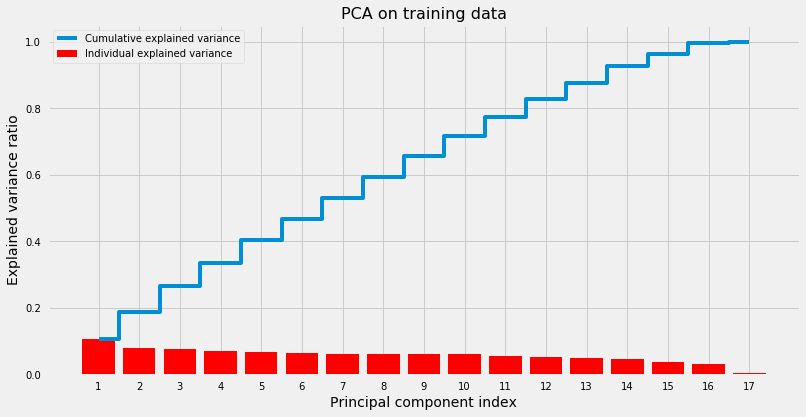

In [7]:
# Build PCA using standarized trained data
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.bar(range(1, 18), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 18), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 18))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});

In [8]:
cum_var_exp

array([ 0.1078147 ,  0.18756726,  0.26523205,  0.33604446,  0.4036422 ,
        0.46807506,  0.53094596,  0.59334034,  0.65535106,  0.71691288,
        0.77413324,  0.82651546,  0.87672244,  0.92515346,  0.96216602,
        0.99429813,  1.        ])

Looks like it needs 14, 15 and 16 principal components to capture 90%, 95% and 99% of the variation in the data respectively. In other words, this means that the data is already in a good space since eigenvalues are very close to each other and gives further evidence that we don't need to compress the data.

The methodology that we'll follow when building the classifiers goes as follows:
1. Build a pipeline that handles all the steps when fitting the classifier using scikit-learn's `make_pipeline` which will have two steps:
    1. Standardizing the data to speed up convergence and make all features on the same scale.
    2. The classifier (`estimator`) we want to use to fit the model.
2. Use `GridSearchCV` to tune hyperparameters using 10-folds cross validation. We can use `RandomizedSearchCV` which is faster and may outperform `GridSearchCV` especially if we have more than two hyperparameters and the range for each one is very big; however, `GridSearchCV` will work just fine since we have only two hyperparameters and descent range.
3. Fit the model using training data.
5. Plot both confusion matrix and ROC curve for the best estimator using test data.

Repeat the above steps for *Random Forest, Gradient Boosting Trees, K-Nearest Neighbors, Logistic Regression and Support Vector Machine*. Next, pick the classifier that has the highest cross validation f1 score. Note that some of the hyperparameter ranges will be guided by the paper [Data-driven Advice for Applying Machine Learning to Bioinformatics Problems](https://arxiv.org/pdf/1708.05070.pdf).

 <h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Random Forest</h2><br>
First, we will start by fitting a Random Forest classifier using unsampled, upsampled and downsampled data. Second, we will evaluate each method using cross validation (CV) f1-score and pick the one with the highest CV f1-score. Finally, we will use that method to fit the rest of the classifiers.

The only hyperparameters we'll tune are:
- `max_feature`: how many features to consider randomly on each split. This will help avoid having few strong features to be picked on each split and let other features have the chance to contribute. Therefore, predictions will be less correlated and the variance of each tree will decrease.
- `min_samples_leaf`: how many examples to have for each split to be a final leaf node.

Random Forest is an ensemble model that has multiple trees (`n_estimators`), where each tree is a weak learner. The final prediction would be a weighting average or mode of the predictions from all estimators. Note: high number of trees don't cause overfitting.

In [9]:
# Build random forest classifier
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "Downsampled": (X_train_d, y_train_d)}

for method in methods_data.keys():
    pip_rf = make_pipeline(StandardScaler(),
                           RandomForestClassifier(n_estimators=500,
                                                  class_weight="balanced",
                                                  random_state=123))
    
    hyperparam_grid = {
        "randomforestclassifier__n_estimators": [10, 50, 100, 500],
        "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5],
        "randomforestclassifier__criterion": ["gini", "entropy"]}
    
    gs_rf = GridSearchCV(pip_rf,
                         hyperparam_grid,
                         scoring="f1",
                         cv=10,
                         n_jobs=-1)
    
    gs_rf.fit(methods_data[method][0], methods_data[method][1])
    
    print("\033[1m" + "\033[0m" + "The best hyperparameters for {} data:".format(method))
    for hyperparam in gs_rf.best_params_.keys():
        print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_rf.best_params_[hyperparam])
        
    print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_rf.best_score_) * 100))

The best hyperparameters for Original data:
criterion :  gini
max_features :  0.5
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 98.19%.
The best hyperparameters for Upsampled data:
criterion :  entropy
max_features :  0.4
min_samples_leaf :  1
n_estimators :  50
Best 10-folds CV f1-score: 99.80%.
The best hyperparameters for Downsampled data:
criterion :  entropy
max_features :  0.4
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 98.44%.


Upsampling yielded the highest CV f1-score with 99.80%. Therefore, we'll be using the upsampled data to fit the rest of the classifiers. The new data now has 18,284 examples with 50% of the examples belong to the positive class and the other 50% belong to the negative example.

In [10]:
X_train_u[y_train_u == 0].shape, X_train_u[y_train_u == 1].shape

((9142, 17), (9142, 17))

Let's refit the Random Forest with Upsampled data using best hyperparameters tuned above and plot confusion matrix and ROC curve using test data.

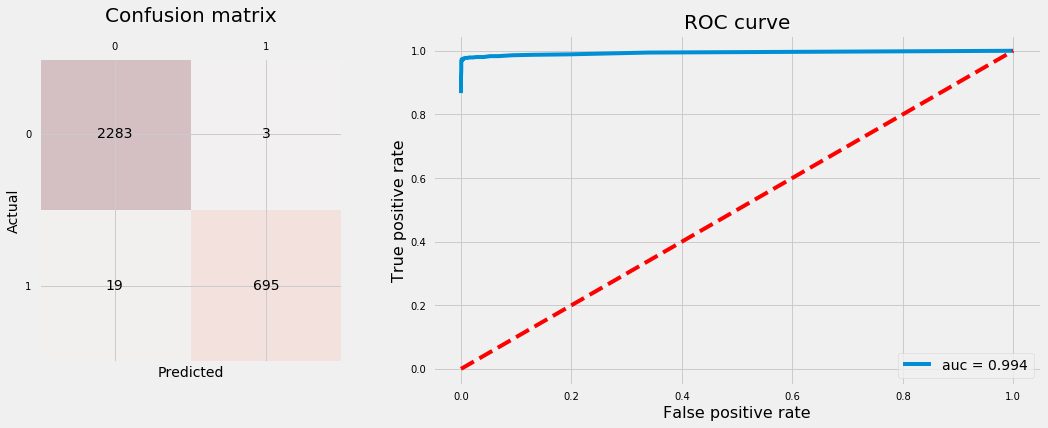

In [11]:
# Reassign original training data to upsampled data
X_train, y_train = np.copy(X_train_u), np.copy(y_train_u)

# Delete original and downsampled data
del X_train_u, y_train_u, X_train_d, y_train_d

# Refit RF classifier using best params
clf_rf = make_pipeline(StandardScaler(),
                       RandomForestClassifier(n_estimators=50,
                                              criterion="entropy",
                                              max_features=0.4,
                                              min_samples_leaf=1,
                                              class_weight="balanced",
                                              n_jobs=-1,
                                              random_state=123))


clf_rf.fit(X_train, y_train)

# Plot confusion matrix and ROC curve
plot_conf_matrix_and_roc(clf_rf, X_test, y_test)

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Gradient Boosting Trees</h2><br>

Gradient Boosting trees are the same as Random Forest except for:
- It starts with small tree and start learning from grown trees by taking into account the residual of grown trees.
- More trees can lead to overfitting; opposite to Random Forest.

The two other hyperparameters than `max_features` and `n_estimators` that we're going to tune are:
- `learning_rate`: rate the tree learns, the slower the better.
- `max_depth`: number of split each time a tree is growing which limits the number of nodes in each tree.

Let's fit GB classifier and plot confusion matrix and ROC curve using test data.

In [12]:
# Build Gradient Boosting classifier
pip_gb = make_pipeline(StandardScaler(),
                       GradientBoostingClassifier(loss="deviance",
                                                  random_state=123))

hyperparam_grid = {"gradientboostingclassifier__max_features": ["log2", 0.5],
                   "gradientboostingclassifier__n_estimators": [100, 300, 500],
                   "gradientboostingclassifier__learning_rate": [0.001, 0.01, 0.1],
                   "gradientboostingclassifier__max_depth": [1, 2, 3]}

gs_gb = GridSearchCV(pip_gb,
                      param_grid=hyperparam_grid,
                      scoring="f1",
                      cv=10,
                      n_jobs=-1)

gs_gb.fit(X_train, y_train)

print("\033[1m" + "\033[0m" + "The best hyperparameters:")
print("-" * 25)
for hyperparam in gs_gb.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_gb.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_gb.best_score_) * 100))

The best hyperparameters:
-------------------------
learning_rate :  0.1
max_depth :  3
max_features :  0.5
n_estimators :  500
Best 10-folds CV f1-score: 97.88%.


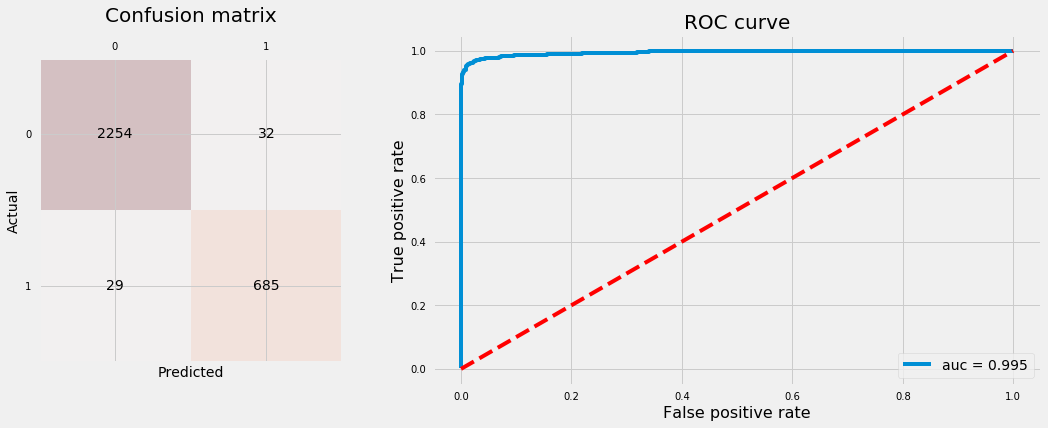

In [13]:
# Plot confusion matrix and ROC curve
plot_conf_matrix_and_roc(gs_gb, X_test, y_test)

 <h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
K-Nearest Neighbors</h2><br>
KNN is called a lazy learning algorithm because it doesn't learn or fit any parameter. It takes `n_neighbors` points from the training data closest to the point we're interested to predict it's class and take the mode (majority vote) of the classes for the neighboring point as its class. The two hyperparameters we're going to tune are:
- `n_neighbors`: number of neighbors to use in prediction.
- `weights`: how much weight to assign neighbors based on:
    - "uniform": all neighboring points have the same weight.
    - "distance": use the inverse of euclidean distance of each neighboring point used in prediction.
    
Let's fit KNN classifier and plot confusion matrix and ROC curve.

In [14]:
# Build KNN classifier
pip_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
hyperparam_range = range(1, 20)

gs_knn = GridSearchCV(pip_knn,
                      param_grid={"kneighborsclassifier__n_neighbors": hyperparam_range,
                                  "kneighborsclassifier__weights": ["uniform", "distance"]},
                      scoring="f1",
                      cv=10,
                      n_jobs=-1)

gs_knn.fit(X_train, y_train)


print("\033[1m" + "\033[0m" + "The best hyperparameters:")
print("-" * 25)
for hyperparam in gs_knn.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_knn.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_knn.best_score_) * 100))

The best hyperparameters:
-------------------------
n_neighbors :  1
weights :  uniform
Best 10-folds CV f1-score: 98.24%.


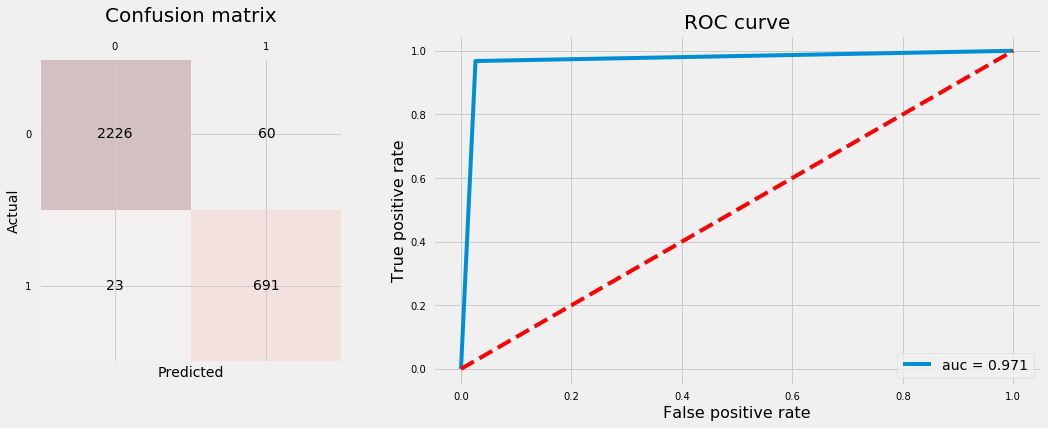

In [15]:
plot_conf_matrix_and_roc(gs_knn, X_test, y_test)

 <h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Logistic Regression</h2><br>
For logistic regression, we'll tune three hyperparameters:
- `penalty`: type of regularization, L2 or L1 regularization.
- `C`: the opposite of regularization of parameter $\lambda$. The higher C the less regularization. We'll use values that cover the full range between unregularized to fully regularized where model is the mode of the examples' label.
- `fit_intercept`: whether to include intercept or not.

We won't use any non-linearities such as polynomial features.

In [16]:
# Build logistic model classifier
pip_logmod = make_pipeline(StandardScaler(),
                           LogisticRegression(class_weight="balanced"))

hyperparam_range = np.arange(0.5, 20.1, 0.5)

hyperparam_grid = {"logisticregression__penalty": ["l1", "l2"],
                   "logisticregression__C":  hyperparam_range,
                   "logisticregression__fit_intercept": [True, False]
                  }

gs_logmodel = GridSearchCV(pip_logmod,
                           hyperparam_grid,
                           scoring="accuracy",
                           cv=2,
                           n_jobs=-1)

gs_logmodel.fit(X_train, y_train)

print("\033[1m" + "\033[0m" + "The best hyperparameters:")
print("-" * 25)
for hyperparam in gs_logmodel.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_logmodel.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_logmodel.best_score_) * 100))

The best hyperparameters:
-------------------------
C :  1.0
fit_intercept :  True
penalty :  l1
Best 10-folds CV f1-score: 77.20%.


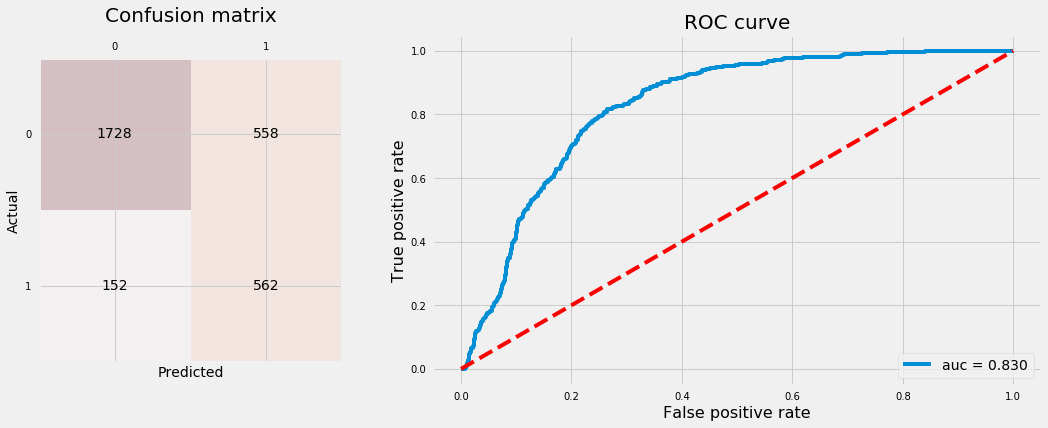

In [17]:
plot_conf_matrix_and_roc(gs_logmodel, X_test, y_test)

 <h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Support Vector Machine (SVM)</h2><br>
SVM is comutationally very expensive to tune it's hyperparameters for two reasons:
1. With big datasets, it becomes very slow.
2. It has good number of hyperparameters to tune that takes very long time to tune on a CPU.

Therefore, we'll use recommended hyperparameters' values from the paper we mentioned before that showed to yield the best performane on Penn Machine Learning Benchmark 165 datasets. The hyperparameters that we usually look to tune are:
- `C`, `gamma`, `kernel`, `degree` and `coef0`

In [18]:
# Build SVM classifier
clf_svc = make_pipeline(StandardScaler(),
                        SVC(C=0.01,
                            gamma=0.1,
                            kernel="poly",
                            degree=5,
                            coef0=10,
                            probability=True))

clf_svc.fit(X_train, y_train)

svc_cv_scores = cross_val_score(clf_svc,
                                X=X_train,
                                y=y_train,
                                scoring="f1",
                                cv=10,
                                n_jobs=-1)

# Print CV
print("\033[1m" + "\033[94m" + "The 10-folds CV f1-score is: {:.2f}%".format(
       np.mean(svc_cv_scores) * 100))

The 10-folds CV f1-score is: 96.38%


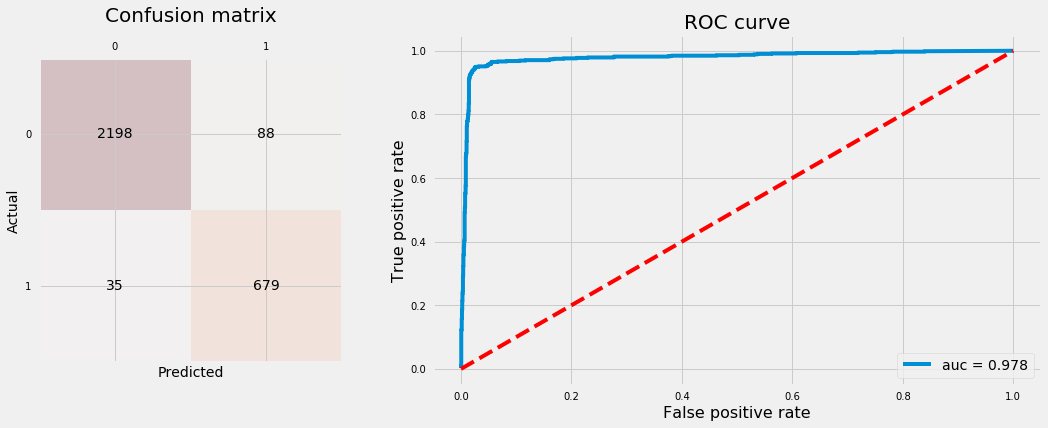

In [19]:
plot_conf_matrix_and_roc(clf_svc, X_test, y_test)

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion</h2><br>

Let’s conclude by printing out the test accuracy rates for all classifiers we’ve trained so far and plot ROC curves. Finally, we’ll pick the classifier that has the highest area under ROC curve.

The accuracy rate and f1-score on test data are:
RF: 99.27%, 98.44%.
LR: 76.33%, 61.29%.
SVC: 95.90%, 91.69%.
GBT: 97.97%, 95.74%.
KNN: 97.23%, 94.33%.


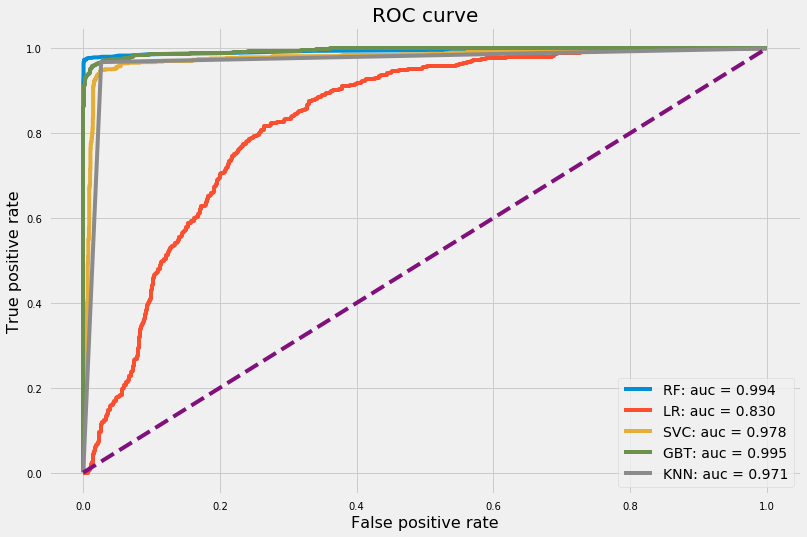

In [20]:
# Plot ROC curves for all classifiers
estimators = {"RF": clf_rf,
              "LR": gs_logmodel,
              "SVC": clf_svc,
              "GBT": gs_gb,
              "KNN": gs_knn}
plot_roc(estimators, X_test, y_test, (12, 8))

# Print out accuracy score on test data
print("The accuracy rate and f1-score on test data are:")
for estimator in estimators.keys():
    print("{}: {:.2f}%, {:.2f}%.".format(estimator,
        accuracy_score(y_test, estimators[estimator].predict(X_test)) * 100,
         f1_score(y_test, estimators[estimator].predict(X_test)) * 100))

Even though Random Forest and Gradient Boosting Trees have almost equal auc, Random Forest has higher accuracy rate and an f1-score with 99.27% and 99.44% respectively. Therefore, we safely say Random Forest outperforms the rest of the classifiers. Let's have a look of feature importances from Random Forest classifier.

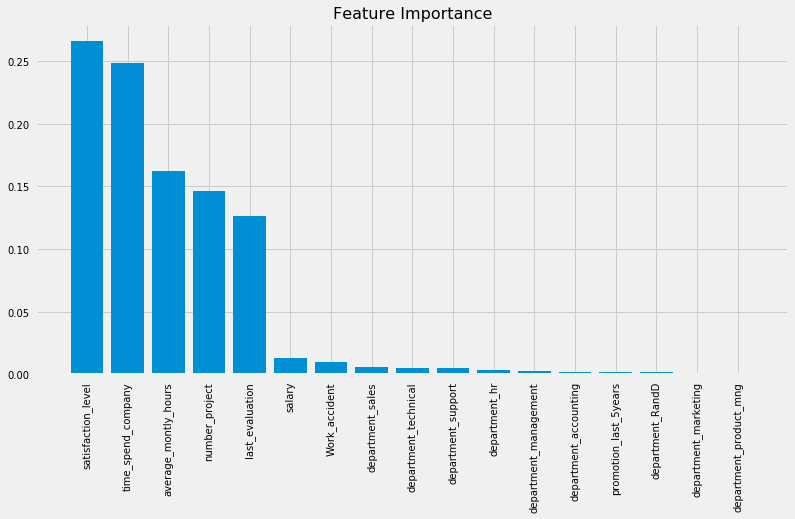

In [21]:
# Refit RF classifier
clf_rf = RandomForestClassifier(n_estimators=50,
                                criterion="entropy",
                                max_features=0.4,
                                min_samples_leaf=1,
                                class_weight="balanced",
                                n_jobs=-1,
                                random_state=123)


clf_rf.fit(StandardScaler().fit_transform(X_train), y_train)

# Plot features importance
importances = clf_rf.feature_importances_
indices = np.argsort(clf_rf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 18), importances[indices], align="center")
plt.xticks(range(1, 18), df.columns[df.columns != "left"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

Looks like the five most important features are:
- satisfaction_level
- time_spend_company
- average_montly_hours
- number_project
- lats_evaluation

The take home message is the following:
- When dealing with imbalanced classes, accuracy is not a good method for model evaluation. AUC and f1-score are examples of metrics we can use.
- Upsampling/downsampling, data synthetic and using balanced class weights are good strategies to try to improve the accuracy of a classifier for imbalanced classes datasets.
- `GridSearchCV` helps tune hyperparameters for each learning algorithm. `RandomizedSearchCV` is faster and may outperform `GridSearchCV` especially when we have more than two hyperparameters to tune.
- Principal Component Analysis (PCA) isn't always recommended especially if the data is in a good feature space and their eigen values are very close to each other.
- As expected, ensemble models outperforms other learning algorithms in most cases.